<a href="https://colab.research.google.com/github/prakashsukhwal/Misc./blob/main/RNN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gather Data using APIs

In [1]:
# data 
# we will try to pull data for AMZN share price
# then we will try to predict the stock prices using vanilla RNN 

In [2]:
!pip install yfinance # uncomment it to download

In [3]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [6]:
# ticker of choice
tick = ['AMZN'] # you can add more or add ticker of choice such as IBM, AAPL, GOOG, GM etc.

# let us start with 2015
begin_period = '2006-01-01'
end_period = '2018-01-01'

In [7]:
import yfinance as yf
# documentation: https://github.com/ranaroussi/yfinance

In [8]:
data = yf.download(tick, start=begin_period, end=end_period)
data.head(4)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,47.470001,47.849998,46.250000,47.580002,47.580002,7582200
2006-01-04,47.490002,47.730000,46.689999,47.250000,47.250000,7440900
2006-01-05,47.160000,48.200001,47.110001,47.650002,47.650002,5417200
2006-01-06,47.970001,48.580002,47.320000,47.869999,47.869999,6152900


## including all weekdays in the data

In [9]:
# quantitative trading strategies often require all weekdays
# df = data.Close
# # let us get all the weekdays in the desired date range
# weekdays = pd.date_range(start= begin_period, end = end_period, freq='B')

# df = df.reindex(weekdays)
# df.head()

In [10]:
# df = pd.DataFrame(df.fillna(method='bfill'))
# df = df.fillna(0)
# df.head()

In [11]:
df = pd.DataFrame(data.Close)
# get rownames as columns
df.index.name = 'Date'
df.reset_index(inplace=True)

In [12]:
print(df.columns)
print(df.dtypes)
print(df.describe)

Index(['Date', 'Close'], dtype='object')
Date     datetime64[ns]
Close           float64
dtype: object
<bound method NDFrame.describe of            Date        Close
0    2006-01-03    47.580002
1    2006-01-04    47.250000
2    2006-01-05    47.650002
3    2006-01-06    47.869999
4    2006-01-09    47.080002
...         ...          ...
3015 2017-12-22  1168.359985
3016 2017-12-26  1176.760010
3017 2017-12-27  1182.260010
3018 2017-12-28  1186.099976
3019 2017-12-29  1169.469971

[3020 rows x 2 columns]>


In [13]:
df.tail(12)

,Date,Close
3008,2017-12-13,1164.130005
3009,2017-12-14,1174.260010
3010,2017-12-15,1179.140015
3011,2017-12-18,1190.579956
3012,2017-12-19,1187.380005
3013,2017-12-20,1177.619995
3014,2017-12-21,1174.760010
3015,2017-12-22,1168.359985
3016,2017-12-26,1176.760010
3017,2017-12-27,1182.260010


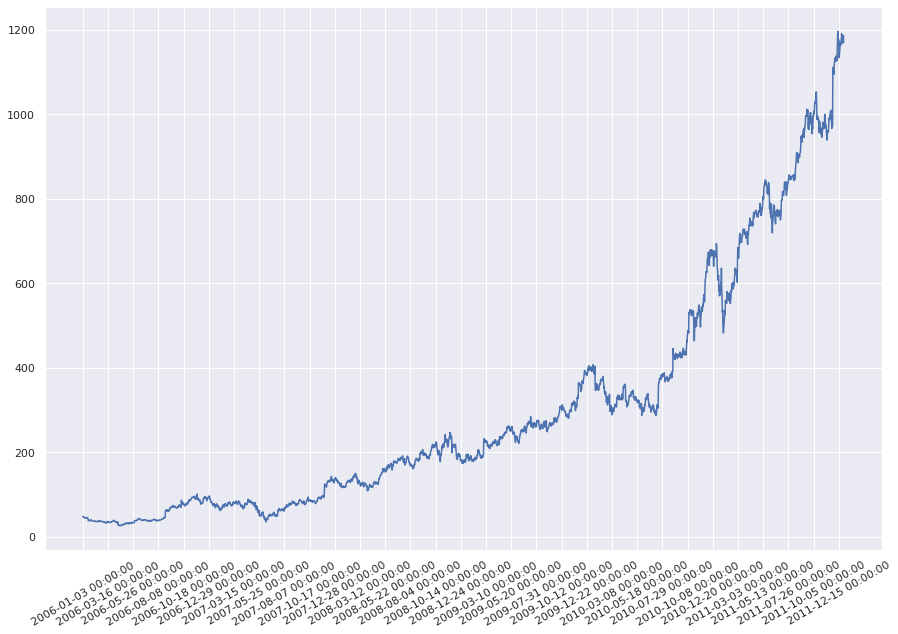

In [14]:
# let us plot this data
# to do:pls complete the figure with adding lables to axes
sns.set_theme()
plt.figure(figsize= (15, 10))
plt.plot(df.Close)
plt.xticks(range(0, df.shape[0], 100), df.Date.loc[::50], rotation=30)
# plt.plot(roll_mean, color='red')

plt.show()

# Data Prep

In [15]:
# min max standardization
scale = MinMaxScaler(feature_range=(-1, 1))
# scale.fit_transform(df.Close.values) # gives error that 2D expected and got 1D
df['Close_norm'] = scale.fit_transform(df.Close.values.reshape(-1, 1))

In [16]:
def train_test_prep(series, window_size, test_prop=0.3): 
  # series should be a numpy series
  series = series.to_numpy()
  data = []
  for i in range(len(series) - window_size):
    data.append(series[i: i+window_size])
  data = np.array(data)

  test_size = int(np.round(test_prop* data.shape[0]))
  train_size = data.shape[0] - test_size

  train_x = data[:train_size, :-1]
  train_y = data[:train_size, -1]

  test_x = data[train_size:, :-1]
  test_y = data[train_size:, -1]

  return [train_x, train_y, test_x, test_y]

In [17]:
ws = 12

x_train, y_train, x_test, y_test = train_test_prep(df[['Close_norm']], ws)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

train_x (2106, 11, 1)
train_y (2106, 1)
test_x (902, 11, 1)
test_y (902, 1)


In [18]:
# data.Close[:25]

In [19]:
# y_train[:5]

In [20]:
# x_train[:5]

In [21]:
#  put all arrays to tensors
x_train = torch.FloatTensor(x_train).cuda()
y_train = torch.FloatTensor(y_train).cuda()

x_test = torch.FloatTensor(x_test).cuda()
y_test = torch.FloatTensor(y_test).cuda()

In [22]:
print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

train_x torch.Size([2106, 11, 1])
train_y torch.Size([2106, 1])
test_x torch.Size([902, 11, 1])
test_y torch.Size([902, 1])


# Vanilla RNN


In [23]:
# batch_size = 200
input_dim = 1
hidden_dim = 100
num_layers = 1
# out_dim = 1
learning_rate = 0.01
epochs = 100

In [24]:
# define RNN
class RNN(nn.Module):
  def __init__(self, input_size=1, hidden_size=100):
    super().__init__()
    self.hidden_size = hidden_size
    
    self.rnn = nn.RNN(input_size = input_size, 
                      hidden_size = hidden_size, 
                      batch_first = True,
                      nonlinearity = 'tanh') # inputs in (batch, seq, features)
    self.fc1 = nn.Linear(hidden_size, 1) # outputing 1 value at the end
    # h0 
    self.hidden = torch.zeros(1,1,self.hidden_size)

  def forward(self, x):
    out, self.hidden =  self.rnn(x.view(1,len(x),-1), 
                                 self.hidden)
    out = out.view(-1, self.hidden_size)
    out = self.fc1(out)
    print('out length: ',out[-1])
    return out[-1]

In [25]:
# initialize model
model = RNN()
loss_function = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
model = model.cuda()
model

RNN(
  (rnn): RNN(1, 100, batch_first=True)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)

In [26]:
next(model.parameters()).is_cuda

True

In [27]:
import time

losses = np.zeros(epochs)
start = time.time()
rnn = []

for epoch in range(epochs):
  optimizer.zero_grad()
  model.hidden = torch.zeros(1,1,model.hidden_size).cuda()
  y_train_pred = model(x_train.view(-1))

  loss = loss_function(y_train_pred, y_train)
  print('Epoch number: ', epoch, 'Error: ', loss.item())
  losses[epoch] = loss.item()
  loss.backward()
  optimizer.step()

print('training took: ', time.time() - start)


out length:  tensor([0.0274], device='cuda:0', grad_fn=<SelectBackward>)
Epoch number:  0 Error:  0.6928635239601135


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([2106, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


out length:  tensor([-0.0234], device='cuda:0', grad_fn=<SelectBackward>)
Epoch number:  1 Error:  0.6126347780227661
out length:  tensor([-0.0710], device='cuda:0', grad_fn=<SelectBackward>)
Epoch number:  2 Error:  0.542111337184906
out length:  tensor([-0.1160], device='cuda:0', grad_fn=<SelectBackward>)
Epoch number:  3 Error:  0.4795699417591095
out length:  tensor([-0.1589], device='cuda:0', grad_fn=<SelectBackward>)
Epoch number:  4 Error:  0.42376893758773804
out length:  tensor([-0.1999], device='cuda:0', grad_fn=<SelectBackward>)
Epoch number:  5 Error:  0.37379124760627747
out length:  tensor([-0.2394], device='cuda:0', grad_fn=<SelectBackward>)
Epoch number:  6 Error:  0.32894444465637207
out length:  tensor([-0.2774], device='cuda:0', grad_fn=<SelectBackward>)
Epoch number:  7 Error:  0.2886941432952881
out length:  tensor([-0.3140], device='cuda:0', grad_fn=<SelectBackward>)
Epoch number:  8 Error:  0.2526180148124695
out length:  tensor([-0.3493], device='cuda:0', grad_f

In [38]:
hist = losses

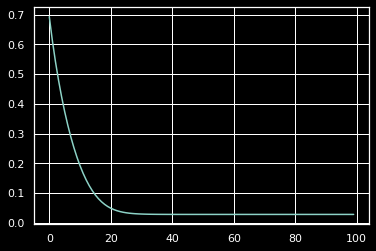

In [39]:
# plt.figure(figsize = (8, 8))
plt.style.use("dark_background") # https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.plot(losses)
plt.xlabel = 'epochs'
plt.ylabel = 'loss values'
plt.show()

In [41]:
predictions = y_train_pred.detach().cpu()
predictions = scale.inverse_transform(np.array(predictions).reshape(-1, 1))
predict = pd.DataFrame(predictions)

In [45]:
len(predict)

1

In [43]:
y_train= y_train.detach().cpu()
original = scale.inverse_transform(np.array(y_train).reshape(-1, 1))
original = pd.DataFrame(original)

In [46]:
len(original)

2106